# Ridge & Lasso Regression

We will be using a small dataset to predict the target variable using basic linear regression, ridge regression and Lasso. First, we import the library functions we need. We disactivate all the warnings.

In [1]:
# import all the required libraries and put matplotlib in inline mode to plot on the notebook
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import model_selection
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

saved_figsize = plt.rcParams['figure.figsize']



We generate the datapoints and plot them.

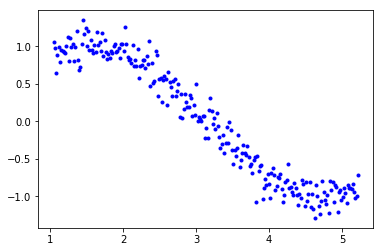

In [2]:
x = np.array([i*np.pi/180 for i in range(60,300,1)])

np.random.seed(10)  #Setting seed for reproducability

y = np.sin(x) + np.random.normal(0,0.15,len(x))

dataset = pd.DataFrame({'x':x, 'y':y})

##
## Split train and test
##

train,test = model_selection.train_test_split(dataset, test_size=0.33, random_state=1234)

plt.plot(dataset['x'],dataset['y'],'.', color='blue');

We define the usual utility functions to compute the value of the polynomial given x, to generate the variables used for polynomial approximation and to plot the resulting approximation.

In [3]:
def compute_polynomial_model(x, coef, intercept):
    """Compute the polynomial given the input x, the intercept and the coefficients"""
    min_x = min(x)
    max_x = max(x)
    xp = np.arange(min_x, max_x, (max_x-min_x)/100.0)

    x = xp
    yp = intercept

    for w in coef:
        yp = yp + w * x
        x = x * xp
    return xp,yp

def generate_variables(original_column, degree):
    """Generates the list of variables for a polynomial approximator"""
    v = [original_column]
    for d in range(2,degree+1):
        v.append(original_column+str(d))
    return v

def add_degrees(dataset,original_column, degree):
    """Given a column name and the degree of a polynomial, it adds 
    all the extra columns needed for a polynomial approximator"""
    
    new_dataset = dataset
    current_column = original_column
    for d in range(2,degree+1):
        column_name = original_column+str(d)

        new_dataset[column_name] = new_dataset[current_column]*dataset[original_column]

        current_column = column_name

    return new_dataset

def plot_approximator(x,y,xp,yp,title=""):
    """Plots the original data (x,y) and a set of point (xp,yp) showing the model approximation"""
    font = {'family' : 'sans',
        'size'   : 14}
    plt.rc('font', **font)

    plt.scatter(x, y,  color='blue')
    plt.plot(xp, yp, color='red', linewidth=3)
    plt.xlabel("x")
    plt.ylabel("y")
    
    if (title!=""):
        plt.title(title)

    plt.show()

We also define the function to compute the polynomial regression for one input variable, one output variable and a degree

In [4]:
def compute_polynomial_regression(dataset, variable, target, degree):
    """Given the dataset the name of the input variable, the target and the degree of the polynomial,
    it computes linear regression using basic least squares"""
    
    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(dataset), degree)
    y = dataset_train_y.reshape(len(dataset), 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    yp = regr.predict(x)

    rss = sum((yp-y)*(yp-y))
    r2 = regr.score(x,y)

    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_[0], regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_[0],regr.intercept_[0])))
    
    return xm, ym, yp, rss[0], r2, regr




Same function with the evaluation using a test set. By default the train/test sets are split as 2/3 1/3

In [5]:
def compute_polynomial_regression_holdout(dataset, variable, target, degree, test_size=0.33, random_state=1234):
    '''Computes RSS and R2 statistics over the train and test set.

    test_size is the percentage of data used for testing (default is 1/3)
    random_state is the seed used for sampling the data and it is used for replicability

    '''
    
    ### Add higher degree of the target variable
    extended_dataset = add_degrees(dataset, variable, degree)

    ### Split train and test
    train_data, test_data = model_selection.train_test_split(extended_dataset, test_size=0.33, random_state=1234)

    ### select only the values that we will be use
    train_x = train_data[generate_variables(variable,degree)].values
    train_y = train_data[target].values

    test_x = test_data[generate_variables(variable,degree)].values
    test_y = test_data[target].values

    ### reshape training and testing data to fit sklearn required format
    train_x = train_x.reshape(len(train_x), degree)
    train_y = train_y.reshape(len(train_y), 1)
    test_x = test_x.reshape(len(test_y), degree)
    test_y = test_y.reshape(len(test_y), 1)

    tss_test = sum((test_y - (sum(test_y)/float(len(test_y))))**2)[0]

    regr = linear_model.LinearRegression()

    regr.fit(train_x, train_y)

    y_predicted_from_test = regr.predict(test_x)
    
    rss_test = sum( (test_y-y_predicted_from_test)*(test_y-y_predicted_from_test) )[0]

    # the abscissa
    xm,ym = compute_polynomial_model(train_x[:,0],regr.coef_[0], regr.intercept_)

    return rss_test, (1-rss_test/tss_test), xm, ym, regr

Let's plot various approximations using different polynomials.

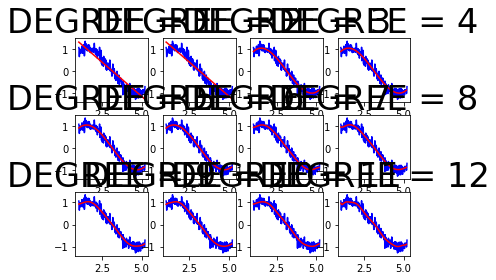

In [6]:
max_polynomial = 12
f, axarr = plt.subplots(3, 4)

plt.rcParams['figure.figsize'] = (40.0, 20.0)
font = {'family' : 'sans', 'size'   : 28}
plt.rc('font', **font)

for degree in range(0,max_polynomial):
    rss, r2, xm, ym, regr = compute_polynomial_regression_holdout(dataset,'x', 'y', degree+1)
#     print(str(degree)+"\t"+str(regr.coef_))
    title = "DEGREE "+str(degree)+" RSS=" + str(round(rss,3))+" R="+str(round(r2,3))
    axarr[int(degree/4),int(degree%4)].plot(dataset['x'],dataset['y'], color="blue")
    axarr[int(degree/4),int(degree%4)].set_title('DEGREE = '+str(degree+1))
    axarr[int(degree/4),int(degree%4)].plot(xm,ym, color="red")
    


Let's plot the largest absolute weight value in each run.

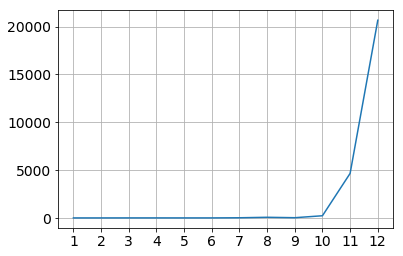

In [7]:
plt.rcParams['figure.figsize'] = saved_figsize
font = {'family' : 'sans', 'size'   : 14}
plt.rc('font', **font)

max_polynomial = 12

weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, rss, r2, regr = compute_polynomial_regression(dataset,'x', 'y', degree+1)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_[0])))
    
plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xticks(range(1,max_polynomial+1))
plt.grid()

We now repeat the process using Ridge regression that define cost as, RSS($\vec{w}$) + $\alpha||\vec{w}||_2^2$

In [8]:
def compute_polynomial_ridge(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(dataset), degree)
    y = dataset_train_y.reshape(len(dataset), 1)

    regr = linear_model.Ridge(alpha=a)
    regr.fit(x, y)

    yp = regr.predict(x)

    rss = sum((yp-y)*(yp-y))
    r2 = regr.score(x,y)

    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_[0], regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_)))

    return xm, ym, yp, rss[0], r2, regr

By penalizing larger weights, ridge regression computes smaller weight values.

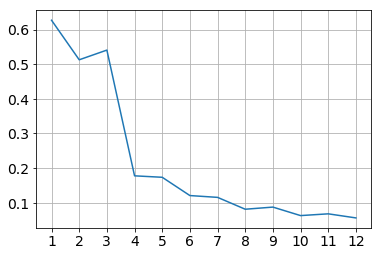

In [9]:
max_polynomial = 12

weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, rss, r2, regr = compute_polynomial_ridge(dataset,'x', 'y', degree+1, a=2.0)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_[0])))
    
plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xticks(range(1,max_polynomial+1))
plt.grid()    

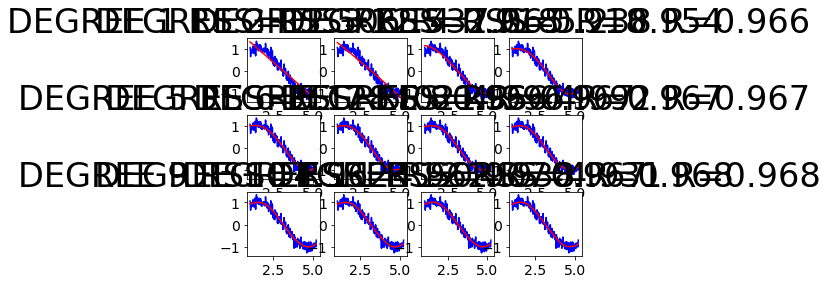

In [10]:
max_polynomial = 12

f, axarr = plt.subplots(3, 4)
font = {'family' : 'sans', 'size'   : 28}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (40.0, 20.0)


for degree in range(0,max_polynomial):
    xm, ym, yp, rss, r2, regr = compute_polynomial_ridge(dataset,'x', 'y', degree+1)
    title = "DEGREE "+str(degree+1)+" RSS=" + str(round(rss,3))+" R="+str(round(r2,3))
    axarr[int(degree/4),int(degree%4)].plot(dataset['x'],dataset['y'], color="blue")
    axarr[int(degree/4),int(degree%4)].set_title(title)
    axarr[int(degree/4),int(degree%4)].plot(xm,ym, color="red")


Let's see how the final weights vary based on the value of $\lambda$ (note that the functions of sklearn use $\alpha$ as a coefficient, but it is equivalent to the lambda in the slides.

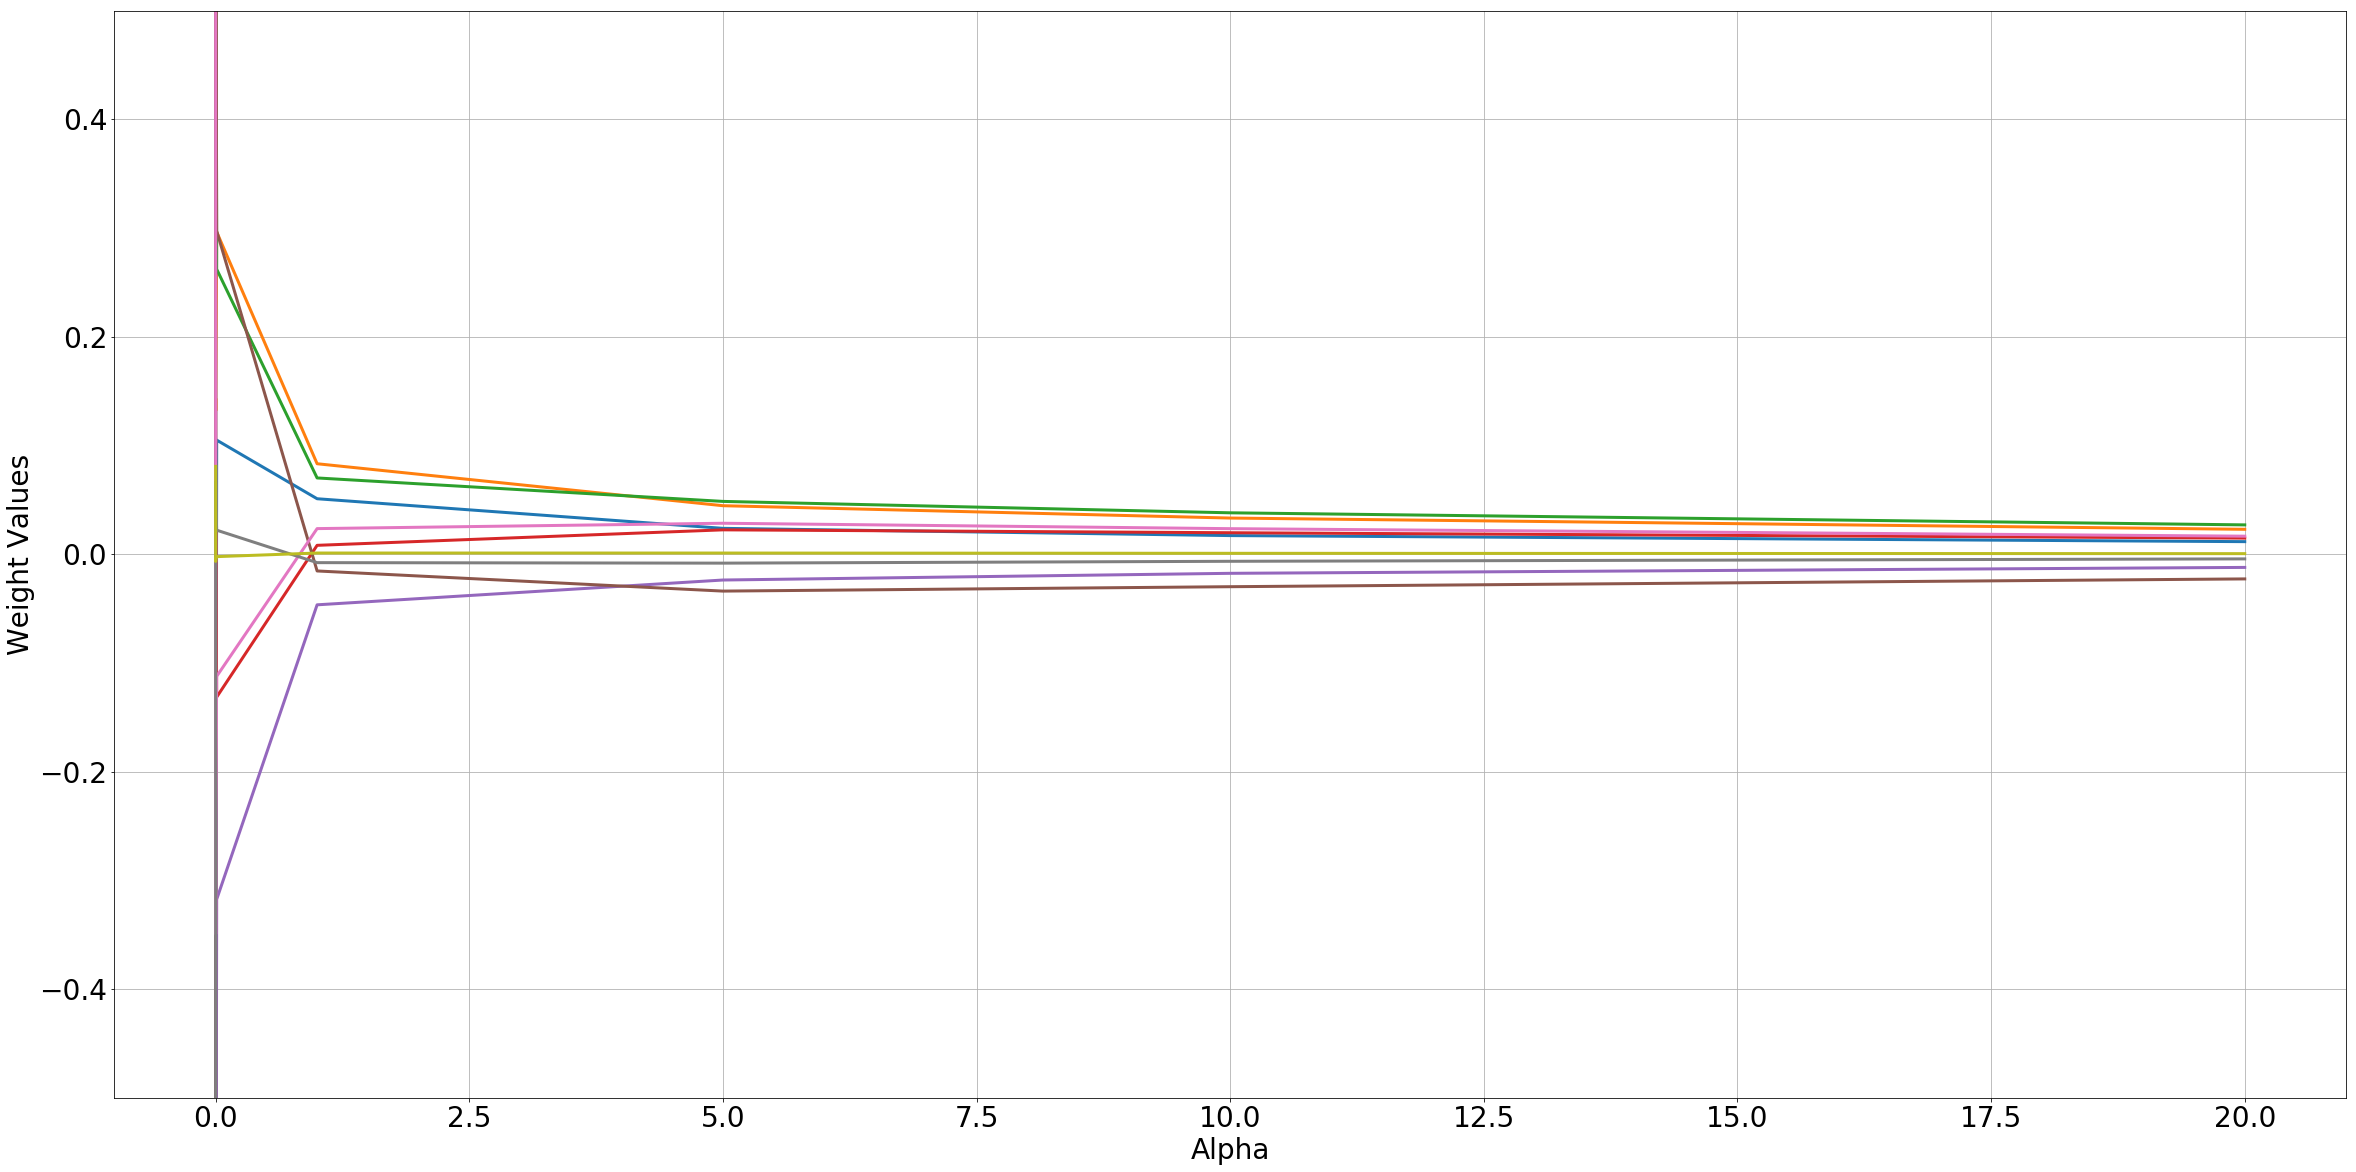

In [11]:
set_of_alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

weights = []

for alpha in set_of_alphas:
    xm, ym, yp, rss, r2, regr = compute_polynomial_ridge(dataset,'x', 'y', 10, a=alpha)
    weights.append(regr.coef_[0])
                   
weight_matrix = pd.DataFrame(weights)

weight_matrix.columns = generate_variables('x',10)


font = {'family' : 'sans',
    'size'   : 28}
plt.rc('font', **font)
    
plt.plot(set_of_alphas, weight_matrix['x'], linewidth=3)
plt.plot(set_of_alphas, weight_matrix['x2'], linewidth=3)
plt.plot(set_of_alphas, weight_matrix['x3'], linewidth=3)
plt.plot(set_of_alphas, weight_matrix['x4'], linewidth=3)
plt.plot(set_of_alphas, weight_matrix['x5'], linewidth=3)
plt.plot(set_of_alphas, weight_matrix['x6'], linewidth=3)
plt.plot(set_of_alphas, weight_matrix['x7'], linewidth=3)
plt.plot(set_of_alphas, weight_matrix['x8'], linewidth=3)
plt.plot(set_of_alphas, weight_matrix['x9'], linewidth=3)
plt.ylim([-0.5,0.5])
plt.xlabel('Alpha')
plt.ylabel('Weight Values')
font = {'family' : 'sans',
    'size'   : 14}
plt.rc('font', **font)
plt.grid()

Let's repeat everything using Lasso regression.

In [12]:
def compute_polynomial_lasso(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(dataset), degree)
    y = dataset_train_y.reshape(len(dataset), 1)

    regr = linear_model.Lasso(alpha=a, max_iter=100000, copy_X=True, normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.005, warm_start=False)
    regr.fit(x, y)

    yp = regr.predict(x)

    rss = sum((yp-y)*(yp-y))
    r2 = regr.score(x,y)

    #print(degree,"\t",regr.coef_)
    
    # the abscissa
    xm,ym = compute_polynomial_model(x[:,0],regr.coef_, regr.intercept_)

    max_weight = np.amax(np.abs(np.array(regr.coef_)))

    #max_weight = np.amax(np.array(regr.coef_[0])) - np.amin(np.array(regr.coef_[0]))
    
    return xm, ym, yp, rss[0], r2, regr

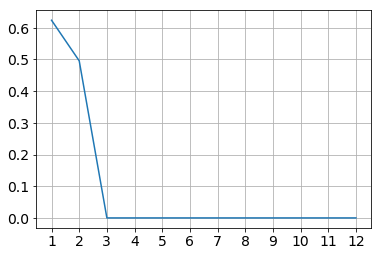

In [13]:
max_polynomial = 12

weight_sum = np.zeros(max_polynomial)

for degree in range(0,max_polynomial):
    xm, ym, yp, rss, r2, regr = compute_polynomial_lasso(dataset,'x', 'y', degree+1, a=0.01)
    weight_sum[degree] = np.amax(np.abs(np.array(regr.coef_[0])))

font = {'family' : 'sans', 'size'   : 14}
plt.rc('font', **font)
plt.rcParams['figure.figsize']=saved_figsize
plt.plot(range(1,max_polynomial+1), weight_sum[range(0,max_polynomial)])
plt.xticks(range(1,max_polynomial+1))
plt.grid()


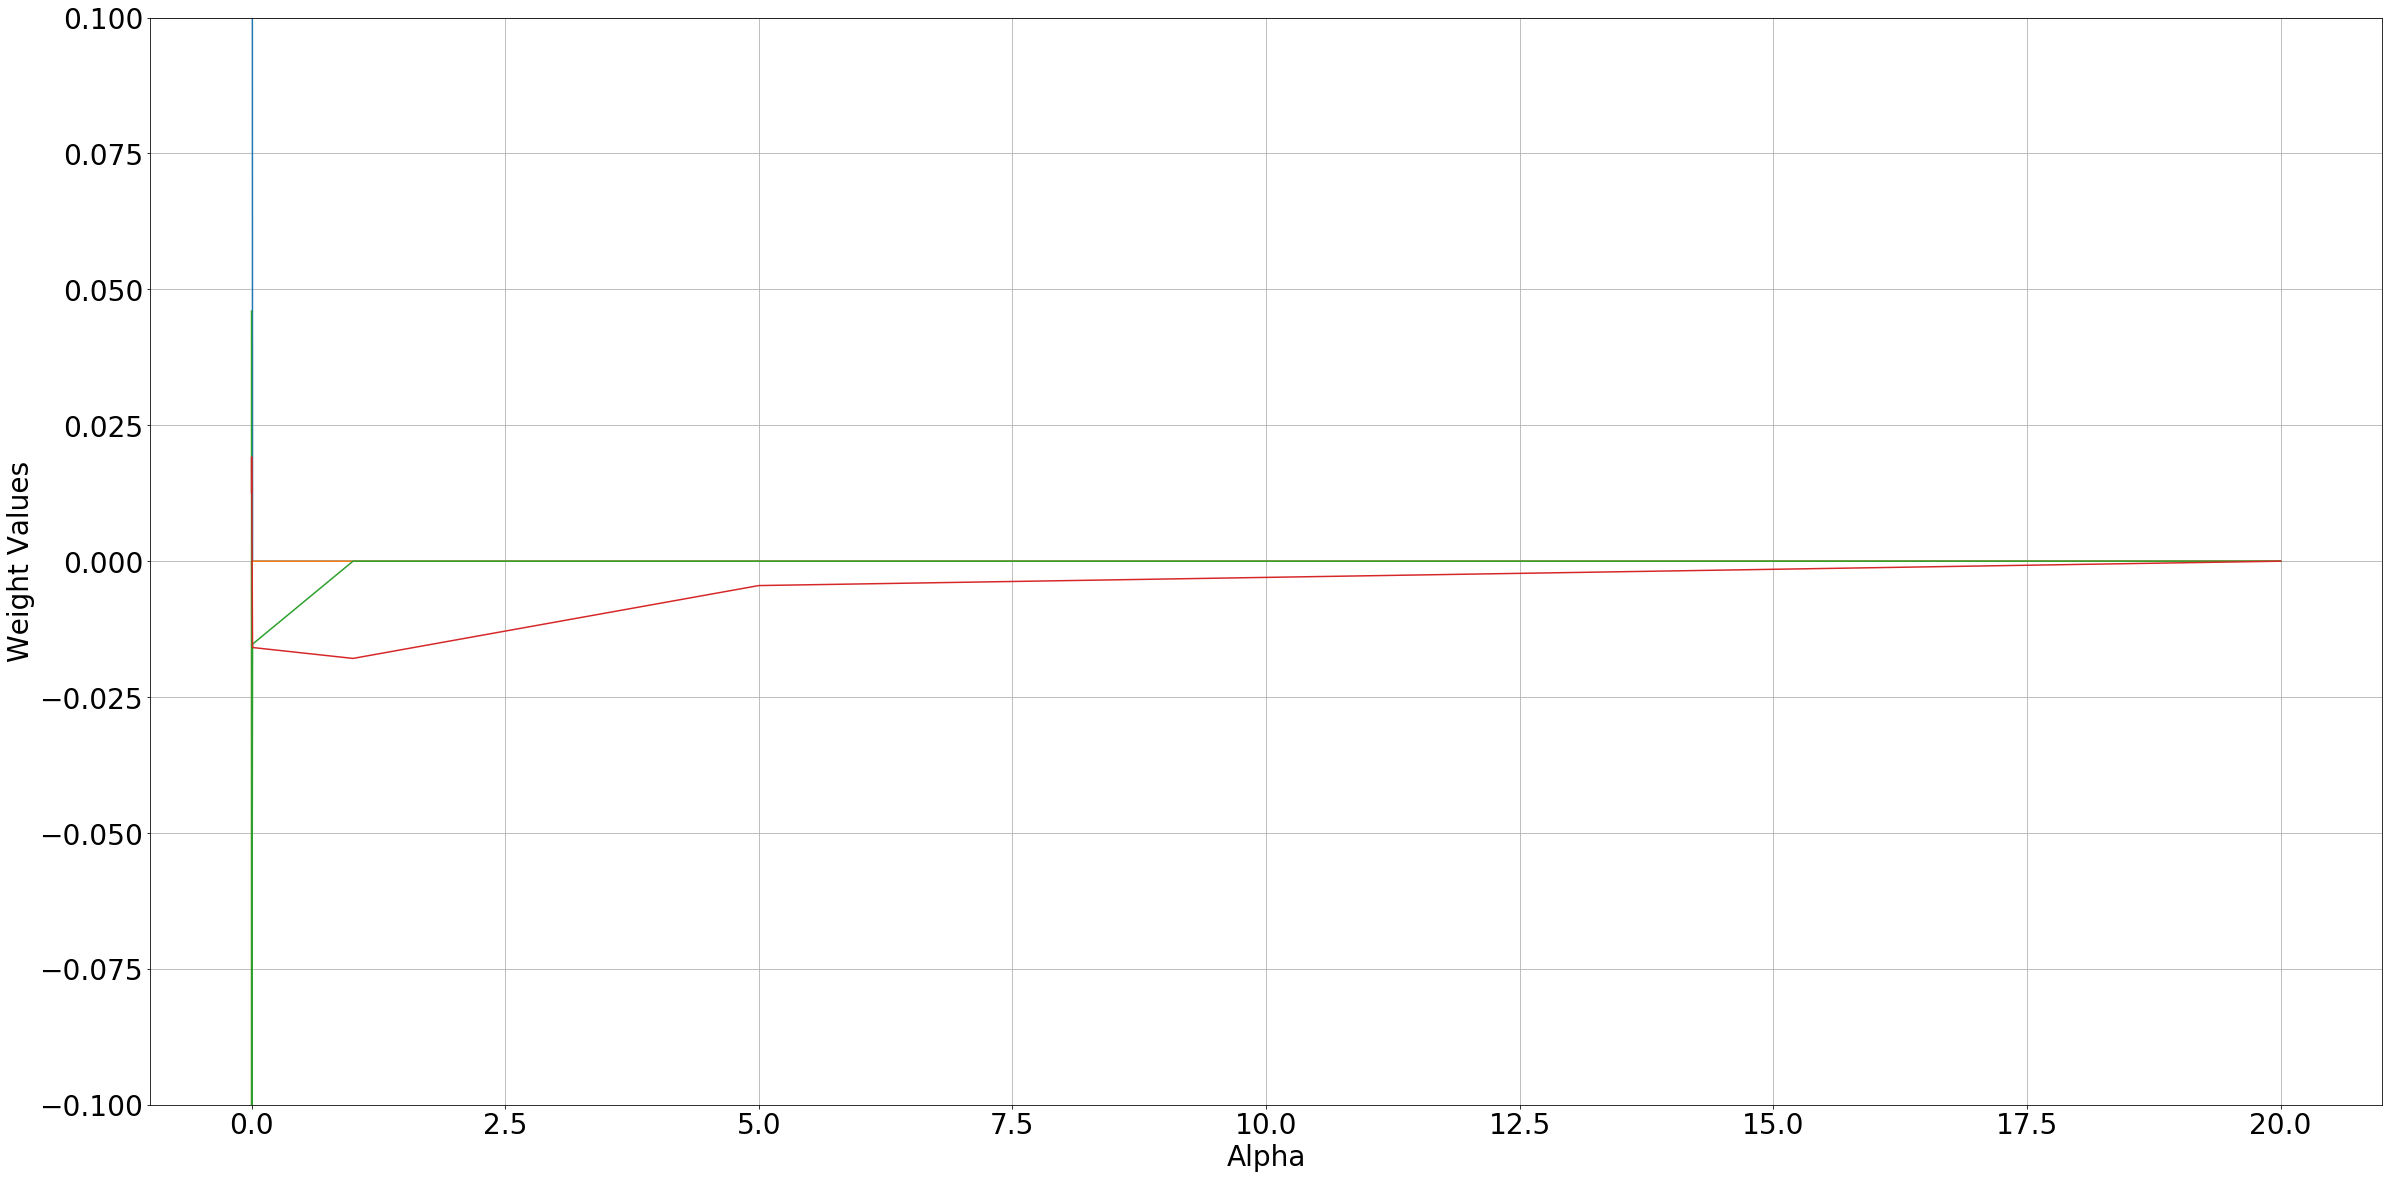

In [14]:
set_of_alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

weights = []

for alpha in set_of_alphas:
    xm, ym, yp, rss, r2, regr = compute_polynomial_lasso(dataset,'x', 'y', 5, a=alpha)
    weights.append(regr.coef_)
                   
weight_matrix = pd.DataFrame(weights)

weight_matrix.columns = generate_variables('x',5)

weight_matrix.shape

plt.rcParams['figure.figsize'] = (40.0, 20.0)
font = {'family' : 'sans',
    'size'   : 28}
plt.rc('font', **font)
plt.plot(set_of_alphas, weight_matrix['x'])
plt.plot(set_of_alphas, weight_matrix['x2'])
plt.plot(set_of_alphas, weight_matrix['x3'])
plt.plot(set_of_alphas, weight_matrix['x4'])
plt.ylim([-.1,.1])
plt.xlabel('Alpha')
plt.ylabel('Weight Values')

plt.grid()


## $\alpha$ Selection using Crossvalidation

We now define a function that given the input and output variables and the degree of the target polynomial compute the model score using 10-fold cross validation. We will use the function to select the best possible $\alpha$

In [15]:
from sklearn.model_selection import cross_val_score

def compute_polynomial_lasso_cv(dataset, variable, target, degree, a=1.0):

    extended_dataset = add_degrees(dataset, variable, degree)

    dataset_train_x = extended_dataset[generate_variables(variable,degree)].values
    dataset_train_y = extended_dataset[target].values

    x = dataset_train_x.reshape(len(extended_dataset), degree)
    y = dataset_train_y.reshape(len(extended_dataset), 1)

    tss = sum((y - (sum(y)/float(len(y))))**2)[0]


    regr = linear_model.Lasso(alpha=a, max_iter=100, tol=0.01, copy_X=True, normalize=False, positive=False, precompute=False)
    scores = cross_val_score(regr, x, y, cv=10)


    rss = (1 - scores)*tss

    return (sum(scores)/10.0), (sum(rss)/10.0)


## Question
- How does the following analysis change if we increase the number of iterations for Lasso?

Let's score the models up to the 15th degree polynomial

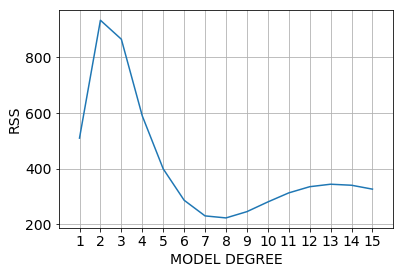

In [16]:
max_polynomial = 15
rss = np.zeros(max_polynomial)
r2 = np.zeros(max_polynomial)

for i in range(max_polynomial):
    r2[i],rss[i] = compute_polynomial_lasso_cv(dataset,'x','y',i+1, a=0.01)

font = {'family' : 'sans', 'size'   : 14}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = saved_figsize

plt.xlabel("MODEL DEGREE")
plt.ylabel("RSS")
plt.grid()
    
plt.plot(range(1,max_polynomial+1), rss)
plt.xlim([0,16]);
plt.xticks(np.arange(1,16,1));

BEST ALPHA =  0.01


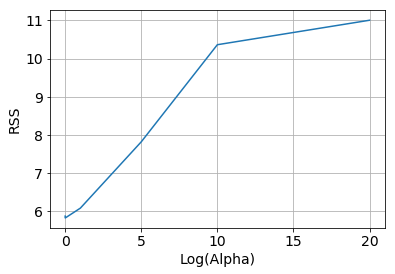

In [ ]:
set_of_alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
rss = np.zeros(len(set_of_alphas))
r2 = np.zeros(len(set_of_alphas))

for i,alpha in enumerate(set_of_alphas):
    r2[i],rss[i] = compute_polynomial_lasso_cv(train,'x','y',8, a=alpha)

plt.xlabel("Log(Alpha)")
plt.ylabel("RSS")
plt.grid()
    
plt.plot(set_of_alphas, rss)

best_alpha_lasso = set_of_alphas[np.argmin(rss)]

print("BEST ALPHA = ",best_alpha_lasso)

In [ ]:
degree = 8
alpha = best_alpha_lasso

rss, r2 = compute_polynomial_lasso_cv(train,'x', 'y', degree, a=best_alpha_lasso)


variable = 'x'
target = 'y'

### evaluate the final RSS
extended_train = add_degrees(train, 'x', degree)
extended_test = add_degrees(test, 'x', degree)

train_x = extended_train[generate_variables(variable,degree)].values.reshape(len(extended_train), degree)
train_y = extended_train[target].values.reshape(len(extended_train), 1)

test_x = extended_test[generate_variables(variable,degree)].values.reshape(len(extended_test), degree)
test_y = extended_test[target].values.reshape(len(extended_test), 1)

regr = linear_model.Lasso(alpha=best_alpha_lasso, max_iter=100, tol=0.01)

regr.fit(train_x,train_y)

r2_train = regr.score(train_x, train_y)

r2_test = regr.score(test_x,test_y)

print("Alpha=", best_alpha_lasso)
print("Weights = ", regr.coef_)
print("R2 Train = ", r2_train)
print("R2 Test = ", r2_test)



